In [2]:
# Utilities
import numpy as np
import pathlib
import PIL 

# ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Evaluation
from sklearn.metrics import confusion_matrix

# Visualization
from matplotlib import pyplot as plt

In [3]:
# Access dataset using paths
frames = pathlib.Path("./frames")

train_frames = frames / "train"
train_norm_frames = train_frames / "norm"
train_weap_frames = train_frames / "weap"

test_frames = frames / "test"
test_norm_frames = test_frames / "norm"
test_weap_frames = test_frames / "weap"

In [4]:
# Basic dataset statistics
print("Number of training frames: {}".format(len(list(train_frames.glob("**/*")))))
print("Training frames statistics:")
print("\tNumber of normal frames: {}".format(len(list(train_norm_frames.glob("**/*")))))
print("\tNumber of weapon frames: {}".format(len(list(train_weap_frames.glob("**/*")))))
print()
print("Number of testing frames: {}".format(len(list(test_frames.glob("**/*")))))
print("Testing frames statistics:")
print("\tNumber of normal frames: {}".format(len(list(test_norm_frames.glob("**/*")))))
print("\tNumber of weapon frames: {}".format(len(list(test_weap_frames.glob("**/*")))))

Number of training frames: 3539
Training frames statistics:
	Number of normal frames: 2059
	Number of weapon frames: 1478

Number of testing frames: 2073
Testing frames statistics:
	Number of normal frames: 1292
	Number of weapon frames: 779


In [5]:
# Load dataset
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_frames,
    validation_split=0.2,
    subset="both",
    seed=123,
    batch_size=batch_size
)

Found 3537 files belonging to 2 classes.
Using 2830 files for training.
Using 707 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['norm', 'weap']


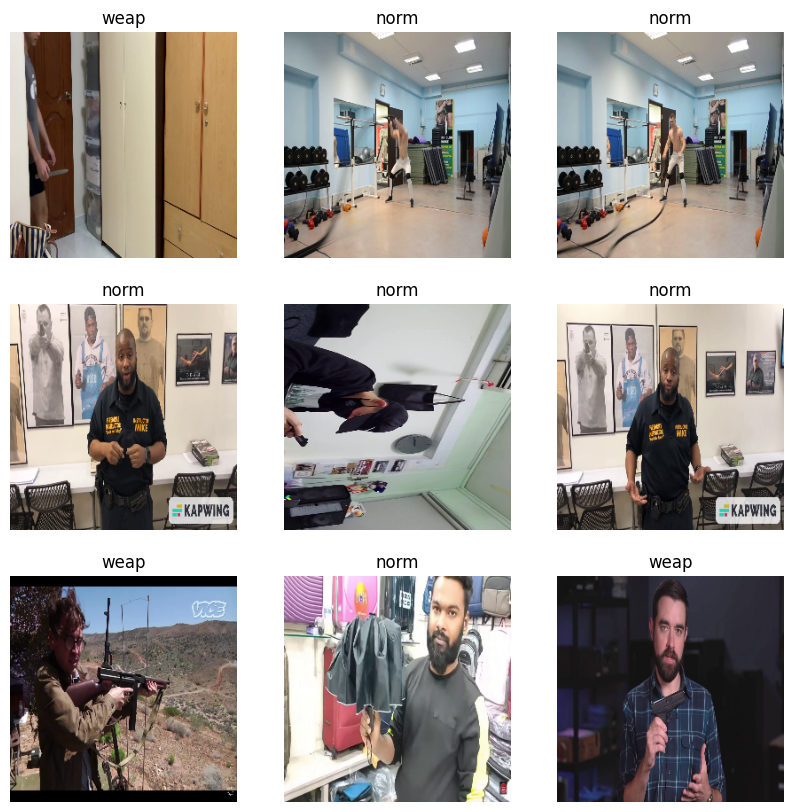

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [9]:
# Dataset configuration
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Dataset standardization
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
# Basic Keras model
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile model
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [13]:
# Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
89/89 [==============================] - 22s 247ms/step - loss: 0.5480 - accuracy: 0.7329 - val_loss: 0.4125 - val_accuracy: 0.8062
Epoch 2/10
89/89 [==============================] - 21s 231ms/step - loss: 0.2078 - accuracy: 0.9177 - val_loss: 0.2304 - val_accuracy: 0.9066
Epoch 3/10
89/89 [==============================] - 21s 232ms/step - loss: 0.0861 - accuracy: 0.9689 - val_loss: 0.2479 - val_accuracy: 0.8967
Epoch 4/10
89/89 [==============================] - 21s 236ms/step - loss: 0.0663 - accuracy: 0.9784 - val_loss: 0.1589 - val_accuracy: 0.9491
Epoch 5/10
89/89 [==============================] - 21s 237ms/step - loss: 0.0259 - accuracy: 0.9947 - val_loss: 0.1369 - val_accuracy: 0.9576
Epoch 6/10
89/89 [==============================] - 21s 237ms/step - loss: 0.0093 - accuracy: 0.9986 - val_loss: 0.1724 - val_accuracy: 0.9519
Epoch 7/10
89/89 [==============================] - 21s 237ms/step - loss: 0.0124 - accuracy: 0.9986 - val_loss: 0.1446 - val_accuracy: 0.9604

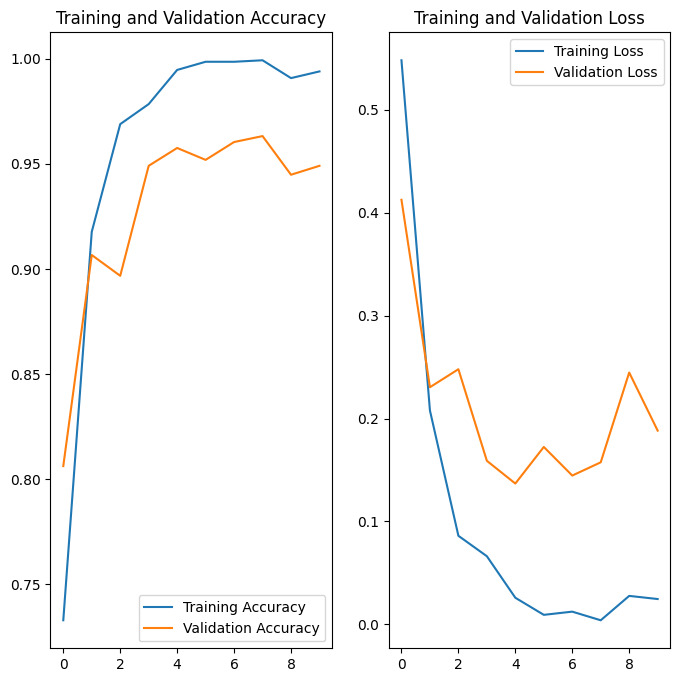

In [14]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = np.array(range(epochs))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# Test the model
num_frames = 0
correct = 0

for frame in test_norm_frames.glob("**/*.png"):
    num_frames += 1
    img = tf.keras.utils.load_img(
        frame, target_size=(256, 256)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = np.array(tf.nn.softmax(predictions[0]))
    if class_names[np.argmax(score)] == "norm":
        correct += 1
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

for frame in test_weap_frames.glob("**/*"):
    num_frames += 1
    img = tf.keras.utils.load_img(
        frame, target_size=(256, 256)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = np.array(tf.nn.softmax(predictions[0]))
    if class_names[np.argmax(score)] == "weap":
        correct += 1
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 [==============================] - 0s 57ms/step
This image most likely belongs to weap with a 100.00 percent confidence.
1/1 [==============================] - 0s 17ms/step
This image most likely belongs to norm with a 99.51 percent confidence.
1/1 [==============================] - 0s 19ms/step
This image most likely belongs to norm with a 99.63 percent confidence.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to norm with a 100.00 percent confidence.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to norm with a 100.00 percent confidence.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to norm with a 100.00 percent confidence.
1/1 [==============================] - 0s 16ms/step
This image most likely belongs to norm with a 100.00 percent confidence.
1/1 [==============================] - 0s 17ms/step
This image most likely belongs to norm with a 100.00 percent confidence.
1/

In [16]:
print('Number of correct classification =', correct, ' out of ', num_frames, ' means ', correct / num_frames)

Number of correct classification = 1241  out of  2071  means  0.5992274263640753
